In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import allel
import itertools
from scipy.stats import chi2_contingency

## Ancestor Allele Call based on Allele Frequency

In [2]:
df = pd.read_table('/home/taeyoon/VcfFiles/bombus-impatiens-snps-final.vcf', sep ='\t', header=None, comment='#')

df.rename(columns={
    0:"scaffold", 1:"pos", 2:"id", 3:"ref", 4:"alt", 5:"quality", 6:"filter", 7:"info", 8:"header",
    9:"1", 10:"10", 11:"11", 12:"2b", 13:"3", 14:"4", 15:"5", 16:"6", 17:"7", 18:"8"}, inplace=True)

In [3]:
column_picks= ["scaffold", "pos", "ref", "alt", "info"]
GT_display= df[column_picks]

In [4]:
GT_display.sort_values(by=['scaffold', 'pos']).head(5)

,scaffold,pos,ref,alt,info
0,NT_176421.1,2767,G,T,AC=9;AF=1.00;AN=9;DP=64;FS=0.000;MLEAC=9;MLEAF...
1,NT_176421.1,3010,G,A,AC=10;AF=1.00;AN=10;BaseQRankSum=1.45;Clipping...
2,NT_176421.1,6525,C,T,AC=10;AF=1.00;AN=10;DP=62;FS=0.000;MLEAC=10;ML...
3,NT_176421.1,6633,T,A,AC=10;AF=1.00;AN=10;BaseQRankSum=1.59;Clipping...
4,NT_176421.1,6661,G,A,AC=10;AF=1.00;AN=10;DP=75;FS=0.000;MLEAC=10;ML...


### Split Info for frequency

In [5]:
#Split the info column to extract AF value, results in string.
df["info"]= df["info"].astype(str)
df["info"]= df["info"].str.split(";", 2)
df["AF"]= df["info"].str.get(1)

In [6]:
df["AF"]= df["AF"].str.split("=")
df["AF_Value"]= df["AF"].str.get(1)
df["AF_Value"].head(10)

0     1.00
1     1.00
2     1.00
3     1.00
4     1.00
5     1.00
6    0.500
7    0.100
8    0.300
9    0.100
Name: AF_Value, dtype: object

In [7]:
#convert string to float, have to make a new category "alt freq"
#otherwise, for some reason, AF_Value column will stay as 'object'
df["Alt_Freq"]= df["AF_Value"].astype(float)

In [8]:
column_picked_2= ["scaffold", "pos", "ref", "alt", "Alt_Freq"]
Allele_and_AF= df[column_picked_2]

In [9]:
Allele_and_AF.sort_values(by=['scaffold', 'pos']).head(5)

,scaffold,pos,ref,alt,Alt_Freq
0,NT_176421.1,2767,G,T,1.0
1,NT_176421.1,3010,G,A,1.0
2,NT_176421.1,6525,C,T,1.0
3,NT_176421.1,6633,T,A,1.0
4,NT_176421.1,6661,G,A,1.0


In [10]:
Allele_and_AF.dtypes

scaffold     object
pos           int64
ref          object
alt          object
Alt_Freq    float64
dtype: object

In [11]:
len(Allele_and_AF) #check initial length

1790181

### Eliminate Alleles with 0 or 1 frequency

In [12]:
Allele_and_AF_2 = Allele_and_AF[Allele_and_AF['Alt_Freq'] != 1.0]

In [13]:
len(Allele_and_AF_2) #check length without AF = 1

1760159

In [14]:
Allele_and_AF_3 = Allele_and_AF_2[Allele_and_AF_2['Alt_Freq'] != 0]

In [15]:
len(Allele_and_AF_3) #check length without AF = 0

1760159

### Call AA based on frequency

In [16]:
#Ancestral Allele, determined based on frequency
#cut off is 0.5, any sitting at 0.5 is discarded
def AA_caller(frequency, reference, alternative):
    if (frequency > 0.5):
        return alternative
    elif (frequency < 0.5):
        return reference
    else:
        return np.nan

In [17]:
#determine Ancestral Allele = AA
Allele_and_AF_3["AA"] = Allele_and_AF_3.apply(lambda row: AA_caller(row["Alt_Freq"], row["ref"], row["alt"]), 
                                              axis= 'columns')

In [18]:
Allele_and_AF_3.head(8)

,scaffold,pos,ref,alt,Alt_Freq,AA
6,NT_176421.1,7050,C,T,0.5,NaN
7,NT_176422.1,477,G,A,0.1,G
8,NT_176422.1,1173,G,A,0.3,G
9,NT_176422.1,1727,A,G,0.1,A
10,NT_176422.1,2347,G,A,0.1,G
11,NT_176422.1,2773,G,A,0.1,G
12,NT_176422.1,2900,C,A,0.4,C
13,NT_176422.1,3458,G,A,0.4,G


In [19]:
#Add column for dervied allele
#take the same script, but swtich positions for alt and ref.
Allele_and_AF_3["Derived"] = Allele_and_AF_3.apply(lambda row: AA_caller(row["Alt_Freq"], row["alt"], row["ref"]), 
                                                   axis= 'columns')

In [20]:
Allele_and_AF_3.head(10)

,scaffold,pos,ref,alt,Alt_Freq,AA,Derived
6,NT_176421.1,7050,C,T,0.5,NaN,NaN
7,NT_176422.1,477,G,A,0.1,G,A
8,NT_176422.1,1173,G,A,0.3,G,A
9,NT_176422.1,1727,A,G,0.1,A,G
10,NT_176422.1,2347,G,A,0.1,G,A
11,NT_176422.1,2773,G,A,0.1,G,A
12,NT_176422.1,2900,C,A,0.4,C,A
13,NT_176422.1,3458,G,A,0.4,G,A
15,NT_176422.1,8291,T,G,0.1,T,G
16,NT_176422.1,9246,T,C,0.1,T,C


In [21]:
#drop NaN, where frequency is 50%
Trimmed_table= Allele_and_AF_3.dropna(how='any')

In [22]:
Trimmed_table.head(10)

,scaffold,pos,ref,alt,Alt_Freq,AA,Derived
7,NT_176422.1,477,G,A,0.1,G,A
8,NT_176422.1,1173,G,A,0.3,G,A
9,NT_176422.1,1727,A,G,0.1,A,G
10,NT_176422.1,2347,G,A,0.1,G,A
11,NT_176422.1,2773,G,A,0.1,G,A
12,NT_176422.1,2900,C,A,0.4,C,A
13,NT_176422.1,3458,G,A,0.4,G,A
15,NT_176422.1,8291,T,G,0.1,T,G
16,NT_176422.1,9246,T,C,0.1,T,C
17,NT_176422.1,10514,T,A,0.7,A,T


### Mutation Direction

In [23]:
#sort mutation by direction, SW and WS
strong_bases= ['G', 'C']
weak_bases= ['A', 'T']

def strength_classifier(ancestor, derived):
    if (ancestor in strong_bases) and (derived in weak_bases):
        return 'SW'
    elif (ancestor in weak_bases) and (derived in strong_bases):
        return 'WS'
    else:
        return 'NN'

In [24]:
Trimmed_table['Strength'] = Trimmed_table.apply(lambda row: strength_classifier(row['AA'], row['Derived']), axis='columns')

/home/taeyoon/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
Trimmed_table.head(10)

,scaffold,pos,ref,alt,Alt_Freq,AA,Derived,Strength
7,NT_176422.1,477,G,A,0.1,G,A,SW
8,NT_176422.1,1173,G,A,0.3,G,A,SW
9,NT_176422.1,1727,A,G,0.1,A,G,WS
10,NT_176422.1,2347,G,A,0.1,G,A,SW
11,NT_176422.1,2773,G,A,0.1,G,A,SW
12,NT_176422.1,2900,C,A,0.4,C,A,SW
13,NT_176422.1,3458,G,A,0.4,G,A,SW
15,NT_176422.1,8291,T,G,0.1,T,G,WS
16,NT_176422.1,9246,T,C,0.1,T,C,WS
17,NT_176422.1,10514,T,A,0.7,A,T,NN


SW    953537
WS    523616
NN    194764
Name: Strength, dtype: int64

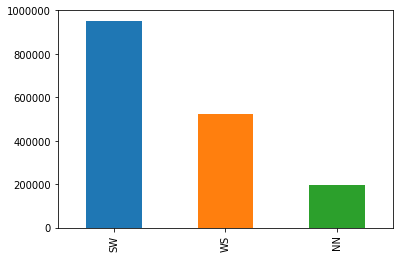

In [26]:
Trimmed_table['Strength'].value_counts().plot(kind='bar')
Trimmed_table['Strength'].value_counts()
#based on allele frequency

In [27]:
#mutliplying GC% of Bombus: 37.9%
#https://www.ncbi.nlm.nih.gov/genome/?term=Bombus%20impatiens
Trimmed_table['Strength'].value_counts().at['SW'] / 0.379

2515928.759894459

In [28]:
Trimmed_table['Strength'].value_counts().at['WS'] / (1 - 0.379)

843181.9645732689

In [29]:
len(Trimmed_table)

1671917

### Mutation Frequency

In [30]:
#Define frequency of the Derived State, the mutation
#if ALT = Derived, keep the original AF, which describes the frequency of the ALT
#if REF = Derived, use 1 - AF

def mutation_frequency (Derived, ALT, AF):
    if Derived == ALT: #this means derived is ALT, which AF is associated with
        return AF
    if Derived != ALT: #this means dervied is REF, which is inversely associated with AF
        return (1-AF)
    else:
        return 'Error'

In [31]:
Trimmed_table['MF'] = Trimmed_table.apply(lambda row: mutation_frequency(row['Derived'], row['alt'], row['Alt_Freq']), 
                                    axis='columns')

/home/taeyoon/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [62]:
Trimmed_table.head(5)

,scaffold,pos,ref,alt,Alt_Freq,AA,Derived,Strength,MF,Barcode
7,NT_176422.1,477,G,A,0.1,G,A,SW,0.1,SW-Rare
8,NT_176422.1,1173,G,A,0.3,G,A,SW,0.3,SW-Common
9,NT_176422.1,1727,A,G,0.1,A,G,WS,0.1,WS-Rare
10,NT_176422.1,2347,G,A,0.1,G,A,SW,0.1,SW-Rare
11,NT_176422.1,2773,G,A,0.1,G,A,SW,0.1,SW-Rare


In [33]:
Trimmed_table['MF'].max()

0.444

In [34]:
Trimmed_table['MF'].min()

0.09999999999999998

In [61]:
Trimmed_table.sort_values(by = ['Alt_Freq']);

### Split bars based on freq, 0.1 and 0.25~0.5

In [36]:
#Ancestry based on allele frequency

def barcoder(strength, frequency):
    if (strength == 'SW') and (frequency <= 0.1):
        return 'SW-Rare'
    elif (strength == 'SW') and (0.25 <= frequency <= 0.5):
        return 'SW-Common'
    elif (strength == 'WS') and (frequency <= 0.1):
        return 'WS-Rare'
    elif (strength == 'WS') and (0.25 <= frequency <= 0.5):
        return 'WS-Common'
    else:
        return 'NaN'

In [37]:
Trimmed_table['Barcode'] = Trimmed_table.apply(lambda row: barcoder(row['Strength'], row['MF']), axis='columns')

/home/taeyoon/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
Trimmed_table['Barcode'].value_counts()

SW-Rare      557999
NaN          499230
WS-Rare      251242
SW-Common    204473
WS-Common    158973
Name: Barcode, dtype: int64

In [39]:
woutNaN = Trimmed_table[Trimmed_table['Barcode'] != 'NaN'] #drops anything between 0.25 and 0.5

SW-Rare      557999
WS-Rare      251242
SW-Common    204473
WS-Common    158973
Name: Barcode, dtype: int64

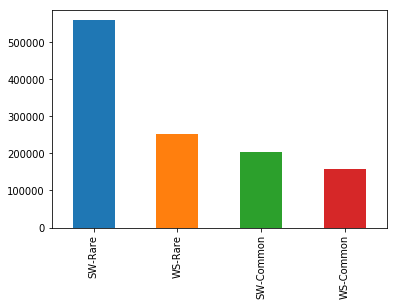

In [40]:
woutNaN['Barcode'].value_counts().plot(kind='bar')
woutNaN['Barcode'].value_counts()

In [41]:
value_only = pd.DataFrame(data = woutNaN['Barcode'].value_counts())
value_only.head(5)

,Barcode
SW-Rare,557999
WS-Rare,251242
SW-Common,204473
WS-Common,158973


In [42]:
value_only.sort_index(ascending = False, inplace= True)

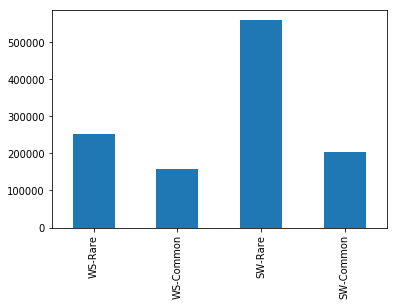

In [43]:
value_only.plot(kind='bar', legend= False)
#this is for AA call made with frequency

#### Take the Freq-based AA and make stacked bar graph. + then adjust for GC%

In [44]:
#Assign names for each category to use in making stacked bar plot
FbAA_WS_R = value_only['Barcode'].at['WS-Rare']
FbAA_WS_C = value_only['Barcode'].at['WS-Common']
FbAA_SW_R = value_only['Barcode'].at['SW-Rare']
FbAA_SW_C = value_only['Barcode'].at['SW-Common']
print(FbAA_SW_C) #check if the stored value is correct
#this one is unadjusted for GC%

204473


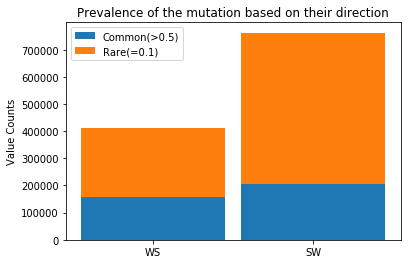

In [45]:
#Stacked bar graph, bombus, unadjusted
N = 2
Common = (FbAA_WS_C, FbAA_SW_C)
Rare = (FbAA_WS_R, FbAA_SW_R)
ind = np.arange(N) # the x locations for the groups
width = 0.9 # the width of the bars: can also be len(x) sequence

FbAA_p1 = plt.bar(ind, Common, width)
FbAA_p2 = plt.bar(ind, Rare, width, bottom=Common)

plt.ylabel('Value Counts')
plt.title('Prevalence of the mutation based on their direction')
plt.xticks(ind, ('WS', 'SW'))
plt.yticks(np.arange(0, 750001, 100000))
plt.legend((FbAA_p1[0], FbAA_p2[0]), ('Common(>0.5)', 'Rare(=0.1)'))

plt.show()

#### Chi-Square Test of the data

In [60]:
#chi square test by manually typing out the array
test = np.array ([[557999, 204473], [251242, 158973]]) #array setup: SW-Rare,Common and WS-Rare,Common
chi2_contingency(test)
#result reported in Chi-value, p-value, df, expected values in array
#(17767.959610959893, 0.0, 1, array([[526162.22722005, 236309.77277995], [283078.77277995, 127136.22722005]]))

(17767.959610959893, 0.0, 1, array([[526162.22722005, 236309.77277995],
        [283078.77277995, 127136.22722005]]))

In [48]:
#values used for array
#SW-Rare 	557999
#WS-Rare 	251242
#SW-Common 	204473
#WS-Common 	158973

'SW-Rare \t542774\n    WS-Rare \t241273\n    SW-Common \t115275\n    WS-Common \t90587'

#### Odds Ratio Test

In [49]:
#defined as (a*d)/(b*c) = OR
#when C/R, OR for SW is:
FbAA_SW_C/FbAA_SW_R
#0.3664397248023742

0.3664397248023742

In [50]:
#OR for WS is:
FbAA_WS_C/FbAA_WS_R
#0.6327485054250483

0.6327485054250483

In [51]:
#OR overall, WS/SW is:
(FbAA_WS_C/FbAA_WS_R)/(FbAA_SW_C/FbAA_SW_R)
#1.7267464813382283

1.7267464813382283

#### Same thing adjusted as per GC% of BImp

In [53]:
#Assign names for each category to use in making stacked bar plot
FbAA_WS_R_adj = (value_only['Barcode'].at['WS-Rare']) / (1-0.379)
FbAA_WS_C_adj = (value_only['Barcode'].at['WS-Common']) / (1-0.379)
FbAA_SW_R_adj = (value_only['Barcode'].at['SW-Rare'] / 0.379)
FbAA_SW_C_adj = (value_only['Barcode'].at['SW-Common'] / 0.379)

print('WSR', FbAA_WS_R, '|', FbAA_WS_R_adj)
print('WSC', FbAA_WS_C, '|', FbAA_WS_C_adj)
print('SWR', FbAA_SW_R, '|', FbAA_SW_R_adj)
print('SWC', FbAA_SW_C, '|', FbAA_SW_C_adj)
#check if the stored value is correct
#this one is Adjusted for GC%, making it mutations 'per' that type of nucleotide

WSR 251242 | 404576.4895330113
WSC 158973 | 255995.16908212562
SWR 557999 | 1472292.875989446
SWC 204473 | 539506.5963060686


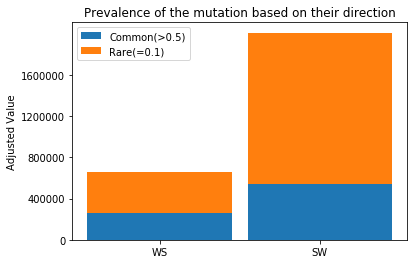

In [54]:
#Stacked bar graph
N = 2
Common_adj = (FbAA_WS_C_adj, FbAA_SW_C_adj)
Rare_adj = (FbAA_WS_R_adj, FbAA_SW_R_adj)
ind = np.arange(N) # the x locations for the groups
width = 0.9 # the width of the bars: can also be len(x) sequence

FbAA_p1_adj = plt.bar(ind, Common_adj, width)
FbAA_p2_adj = plt.bar(ind, Rare_adj, width, bottom=Common_adj)

plt.ylabel('Adjusted Value')
plt.title('Prevalence of the mutation based on their direction')
plt.xticks(ind, ('WS', 'SW'))
plt.yticks(np.arange(0, 1800001, 400000))
plt.legend((FbAA_p1_adj[0], FbAA_p2_adj[0]), ('Common(>0.5)', 'Rare(=0.1)'))

plt.show()

#### Chi-square and Odd's Ratio for Adjusted Bimp

In [63]:
#Chi square
test_adjust = np.array ([[1472292.875989446, 539506.5963060686], [404576.4895330113, 255995.16908212562]]) 
#array setup: SW-Rare,Common and WS-Rare,Common
chi2_contingency(test_adjust)
#this returns chi-sqaure, p, degrees of freedom, and expected values in array
#(33889.90191377693, 0.0, 1, array([[1412934.28725186,  598865.18504365],[ 463935.07827059,  196636.58034454]]

(33889.90191377693, 0.0, 1, array([[1412934.28725186,  598865.18504365],
        [ 463935.07827059,  196636.58034454]]))

In [66]:
#OR overall, WS/SW is:
(FbAA_WS_C_adj/FbAA_WS_R_adj)/(FbAA_SW_C_adj/FbAA_SW_R_adj)
#no change becasue numerator and denominator gets divided by the same value.

1.7267464813382283

## Repeated on Polistes

In [67]:
%%time
pol_df = pd.read_table('/data3/arshad_PNAS_data/For_Tae/polistes-snps.vcf', sep ='\t', header=None, comment='#')

pol_df.rename(columns={
    0:"scaffold", 1:"pos", 2:"id", 3:"ref", 4:"alt", 5:"quality", 6:"filter", 7:"info", 8:"header", 
    9:"1", 10:"10", 11:"11", 12:"2b", 13:"3", 14:"4", 15:"5", 16:"6", 17:"7", 18:"8"}, inplace=True)

CPU times: user 23.1 s, sys: 2.08 s, total: 25.1 s
Wall time: 25.1 s


In [68]:
pol_column_picks= ["scaffold", "pos", "ref", "alt", "info"]
pol_GT_display= pol_df[pol_column_picks]

In [70]:
pol_GT_display.sort_values(by=['scaffold', 'pos']).head()

,scaffold,pos,ref,alt,info
0,PdomSCFr1.2-0001,74,G,C,AC=9;AF=0.450;AN=20;BaseQRankSum=0.286;Clippin...
1,PdomSCFr1.2-0001,91,A,T,AC=10;AF=0.500;AN=20;BaseQRankSum=0.185;Clippi...
2,PdomSCFr1.2-0001,94,G,C,AC=4;AF=0.200;AN=20;BaseQRankSum=-5.900e-02;Cl...
3,PdomSCFr1.2-0001,101,C,A,AC=8;AF=0.400;AN=20;BaseQRankSum=0.469;Clippin...
4,PdomSCFr1.2-0001,135,C,T,AC=9;AF=0.450;AN=20;BaseQRankSum=0.457;Clippin...


### Split info to Frequency

In [74]:
pol_df['AF'] = pol_df['info'].str.split('AF=').str.get(1).str.split(';').str.get(0)

In [72]:
#convert string to float, have to make a new category "alt frequency"
#otherwise, for some reason, AF_Value column will stay as 'object'
pol_df["Alt_Freq"]= pol_df["AF"].astype(float)

In [75]:
pol_column_picked_2= ["scaffold", "pos", "ref", "alt", "Alt_Freq"]
pol_Allele_and_AF= pol_df[pol_column_picked_2]
pol_Allele_and_AF.sort_values(by=['scaffold', 'pos']).head(5)

,scaffold,pos,ref,alt,Alt_Freq
0,PdomSCFr1.2-0001,74,G,C,0.45
1,PdomSCFr1.2-0001,91,A,T,0.50
2,PdomSCFr1.2-0001,94,G,C,0.20
3,PdomSCFr1.2-0001,101,C,A,0.40
4,PdomSCFr1.2-0001,135,C,T,0.45


In [76]:
len(pol_Allele_and_AF)

3006260

### Eliminate Alleles with 0 or 1 frequency

In [77]:
pol_Allele_and_AF_2 = pol_Allele_and_AF[pol_Allele_and_AF['Alt_Freq'] != 1.0]
pol_Allele_and_AF_3 = pol_Allele_and_AF_2[pol_Allele_and_AF_2['Alt_Freq'] != 0]

In [78]:
pol_Allele_and_AF_3.head()

,scaffold,pos,ref,alt,Alt_Freq
0,PdomSCFr1.2-0001,74,G,C,0.45
1,PdomSCFr1.2-0001,91,A,T,0.50
2,PdomSCFr1.2-0001,94,G,C,0.20
3,PdomSCFr1.2-0001,101,C,A,0.40
4,PdomSCFr1.2-0001,135,C,T,0.45


In [79]:
len(pol_Allele_and_AF_3)

2927620

In [83]:
pol_Allele_and_AF_3['Alt_Freq'].min() #check min, must be above 0

0.05

In [84]:
pol_Allele_and_AF_3['Alt_Freq'].max() #check max, must be below 1

0.95

### Call AA based on Frequency

In [85]:
#reuse function from previous
pol_Allele_and_AF_3["AA"] = pol_Allele_and_AF_3.apply(lambda row: AA_caller(row["Alt_Freq"], row["ref"], row["alt"]), 
                                                      axis= 'columns')

In [86]:
#Add column for dervied allele
#take the same script, but swtich positions for alt and ref.
pol_Allele_and_AF_3["Derived"] = pol_Allele_and_AF_3.apply(lambda row: AA_caller(row["Alt_Freq"], row["alt"], row["ref"]), 
                                                           axis= 'columns')

In [87]:
#drop NaN
pol_Trimmed_table= pol_Allele_and_AF_3.dropna(how='any')

In [88]:
len(pol_Trimmed_table)

2848125

### Mutation Direction

In [89]:
#reuse strength_classifier from previous
pol_Trimmed_table['Strength'] = pol_Trimmed_table.apply(lambda row: strength_classifier(row['AA'], row['Derived']), 
                                                        axis='columns')

/home/taeyoon/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [90]:
pol_Trimmed_table.head(5)

,scaffold,pos,ref,alt,Alt_Freq,AA,Derived,Strength
0,PdomSCFr1.2-0001,74,G,C,0.45,G,C,NN
2,PdomSCFr1.2-0001,94,G,C,0.20,G,C,NN
3,PdomSCFr1.2-0001,101,C,A,0.40,C,A,SW
4,PdomSCFr1.2-0001,135,C,T,0.45,C,T,SW
5,PdomSCFr1.2-0001,136,A,T,0.10,A,T,NN


SW    1385187
WS     847624
NN     615314
Name: Strength, dtype: int64

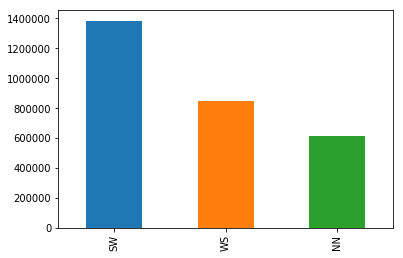

In [91]:
pol_Trimmed_table['Strength'].value_counts().plot(kind='bar')
pol_Trimmed_table['Strength'].value_counts()

In [92]:
#general comment: also largely S->W. Not sure why AT would be more often found in smaller frequency than GC.

### Mutation Frequency

In [93]:
pol_Trimmed_table['MF'] = pol_Trimmed_table.apply(lambda row: mutation_frequency(row['Derived'], row['alt'], row['Alt_Freq']), 
                                    axis='columns')

/home/taeyoon/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Splitting the Bar graph

In [94]:
pol_Trimmed_table['Barcode'] = pol_Trimmed_table.apply(lambda row: barcoder(row['Strength'], row['MF']), axis='columns')

/home/taeyoon/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [95]:
pol_Trimmed_table.head(5)

,scaffold,pos,ref,alt,Alt_Freq,AA,Derived,Strength,MF,Barcode
0,PdomSCFr1.2-0001,74,G,C,0.45,G,C,NN,0.45,NaN
2,PdomSCFr1.2-0001,94,G,C,0.20,G,C,NN,0.20,NaN
3,PdomSCFr1.2-0001,101,C,A,0.40,C,A,SW,0.40,SW-Common
4,PdomSCFr1.2-0001,135,C,T,0.45,C,T,SW,0.45,SW-Common
5,PdomSCFr1.2-0001,136,A,T,0.10,A,T,NN,0.10,NaN


In [96]:
len(pol_Trimmed_table)

2848125

In [97]:
pol_woutNaN = pol_Trimmed_table[pol_Trimmed_table['Barcode'] != 'NaN']
len(pol_woutNaN)

1789949

In [98]:
pol_value_only = pd.DataFrame(data = pol_woutNaN['Barcode'].value_counts())
pol_value_only.sort_index(ascending = False, inplace= True)
pol_value_only.head(5)

,Barcode
WS-Rare,433182
WS-Common,239987
SW-Rare,824597
SW-Common,292183


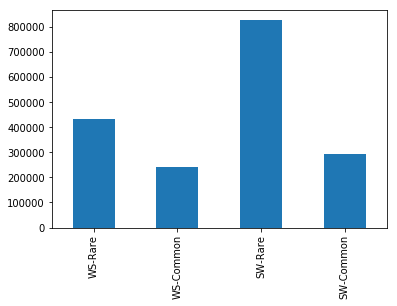

In [99]:
pol_value_only.plot(kind='bar', legend= False)

#### Polistes Stacked Bar plot

In [100]:
#Assign names for each category to use in making stacked bar plot
pol_FbAA_WS_R = pol_value_only['Barcode'].at['WS-Rare']
pol_FbAA_WS_C = pol_value_only['Barcode'].at['WS-Common']
pol_FbAA_SW_R = pol_value_only['Barcode'].at['SW-Rare']
pol_FbAA_SW_C = pol_value_only['Barcode'].at['SW-Common']
print(pol_FbAA_SW_C) #check if the stored value is correct
#this one is unadjusted for GC%

292183


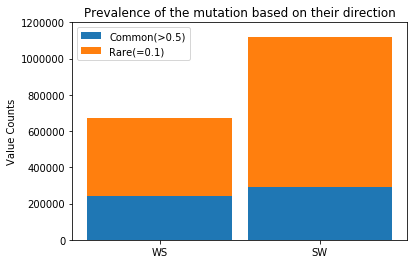

In [101]:
#Stacked bar graph
N = 2
pol_Common = (pol_FbAA_WS_C, pol_FbAA_SW_C)
pol_Rare = (pol_FbAA_WS_R, pol_FbAA_SW_R)
ind = np.arange(N) # the x locations for the groups
width = 0.9 # the width of the bars: can also be len(x) sequence

pol_FbAA_p1 = plt.bar(ind, pol_Common, width)
pol_FbAA_p2 = plt.bar(ind, pol_Rare, width, bottom=pol_Common)

plt.ylabel('Value Counts')
plt.title('Prevalence of the mutation based on their direction')
plt.xticks(ind, ('WS', 'SW'))
plt.yticks(np.arange(0, 1200001, 200000))
plt.legend((FbAA_p1[0], FbAA_p2[0]), ('Common(>0.5)', 'Rare(=0.1)'))

plt.show()

#### Chi Square Test on Polistes

In [103]:
#chi square test by manually typing out the array
test = np.array ([[824597, 292183], [433182, 239987]]) #array setup: SW-Rare,Common and WS-Rare,Common
chi2_contingency(test)
#output is in the order of X-value, p-value, dof, and the array of expected
#(18094.9100970834, 0.0, 1, array([[784749.97422832, 332030.02577168], [473029.02577168, 200139.97422832]]))

(18094.9100970834, 0.0, 1, array([[784749.97422832, 332030.02577168],
        [473029.02577168, 200139.97422832]]))

In [ ]:
#the value counts for reference 
#WS-Rare 	433182
#WS-Common 	239987
#SW-Rare 	824597
#SW-Common 	292183

#### Odds Ratio Test on Polistes

In [105]:
#defined as (a*d)/(b*c) = OR
#when C/R, OR for SW is:
print(pol_FbAA_SW_C/pol_FbAA_SW_R)
#0.3543342990576003
#OR for WS is:
print(pol_FbAA_WS_C/pol_FbAA_WS_R)
#0.5540096310557687
#OR overall, WS/SW is:
print((pol_FbAA_WS_C/pol_FbAA_WS_R)/(pol_FbAA_SW_C/pol_FbAA_SW_R))
#OR = 1.5635224490805204

0.3543342990576003
0.5540096310557687
1.5635224490805204


#### GC content adjusted Polistes

In [106]:
#https://www.ncbi.nlm.nih.gov/genome/?term=Polistes+dominula
#GC%: 31.5
#Assign names for each category to use in making stacked bar plot
pol_FbAA_WS_R_adj = (pol_value_only['Barcode'].at['WS-Rare']) / (1-0.315)
pol_FbAA_WS_C_adj = (pol_value_only['Barcode'].at['WS-Common']) / (1-0.315)
pol_FbAA_SW_R_adj = (pol_value_only['Barcode'].at['SW-Rare'] / 0.315)
pol_FbAA_SW_C_adj = (pol_value_only['Barcode'].at['SW-Common'] / 0.315)

print('WSR', pol_FbAA_WS_R, '|', pol_FbAA_WS_R_adj)
print('WSC', pol_FbAA_WS_C, '|', pol_FbAA_WS_C_adj)
print('SWR', pol_FbAA_SW_R, '|', pol_FbAA_SW_R_adj)
print('SWC', pol_FbAA_SW_C, '|', pol_FbAA_SW_C_adj)
#check if the stored value is correct
#this one is Adjusted for GC%, making it mutations 'per' that type of nucleotide

WSR 433182 | 632382.4817518247
WSC 239987 | 350345.98540145985
SWR 824597 | 2617768.2539682537
SWC 292183 | 927565.0793650794


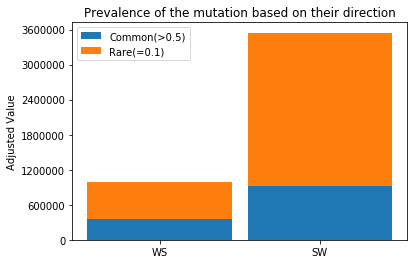

In [107]:
#Stacked bar graph
N = 2
pol_Common_adj = (pol_FbAA_WS_C_adj, pol_FbAA_SW_C_adj)
pol_Rare_adj = (pol_FbAA_WS_R_adj, pol_FbAA_SW_R_adj)
ind = np.arange(N) # the x locations for the groups
width = 0.9 # the width of the bars: can also be len(x) sequence

pol_FbAA_p1_adj = plt.bar(ind, pol_Common_adj, width)
pol_FbAA_p2_adj = plt.bar(ind, pol_Rare_adj, width, bottom=pol_Common_adj)

plt.ylabel('Adjusted Value')
plt.title('Prevalence of the mutation based on their direction')
plt.xticks(ind, ('WS', 'SW'))
plt.yticks(np.arange(0, 3600001, 600000))
plt.legend((FbAA_p1_adj[0], FbAA_p2_adj[0]), ('Common(>0.5)', 'Rare(=0.1)'))

plt.show()

In [108]:
#chi square test by manually typing out the array
test = np.array ([[2617768.2539682537, 927565.0793650794], [632382.4817518247, 350345.98540145985]]) #array setup: SW-Rare,Common and WS-Rare,Common
chi2_contingency(test)
#output is in the order of X-value, p-value, dof, and the array of expected
#(34188.69603624954, 0.0, 1, array([[2544768.21417674, 1000565.11915659], [ 705382.52154334,  277345.94560995]]))

(34188.69603624954, 0.0, 1, array([[2544768.21417674, 1000565.11915659],
        [ 705382.52154334,  277345.94560995]]))